In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from scipy.integrate import simps
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

## Xray luminosity

In [4]:
loudFile = open('RL_xray.txt','r')
X_loud = loudFile.readline().split()
quietFile = open('RQ_xray.txt','r')
X_quiet = quietFile.readline().split()

In [5]:
X_quiet = np.array(map(float, X_quiet))
X_loud = np.array(map(float, X_loud))

(array([ 8.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.67299000e+24,   7.12378100e+24,   1.25745720e+25,
          1.80253630e+25,   2.34761540e+25,   2.89269450e+25,
          3.43777360e+25,   3.98285270e+25,   4.52793180e+25,
          5.07301090e+25,   5.61809000e+25]),
 <a list of 10 Patch objects>)

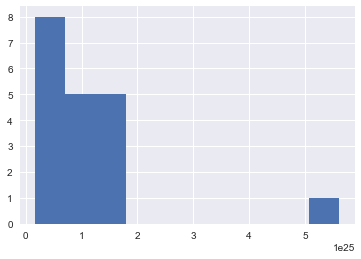

In [6]:
plt.hist(X_quiet)

(array([ 26.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.46427000e+24,   5.00789178e+28,   1.00155371e+29,
          1.50231825e+29,   2.00308279e+29,   2.50384732e+29,
          3.00461186e+29,   3.50537639e+29,   4.00614093e+29,
          4.50690546e+29,   5.00767000e+29]),
 <a list of 10 Patch objects>)

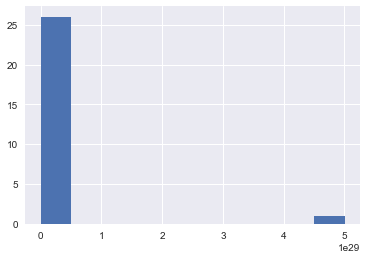

In [7]:
plt.hist(X_loud)

In [8]:
log_X_quiet = np.log10(X_quiet)
log_X_loud = np.log10(X_loud)

(array([ 1.,  0.,  4.,  2.,  3.,  4.,  4.,  0.,  0.,  1.]),
 array([ 24.22349335,  24.37610288,  24.52871241,  24.68132195,
         24.83393148,  24.98654102,  25.13915055,  25.29176009,
         25.44436962,  25.59697916,  25.74958869]),
 <a list of 10 Patch objects>)

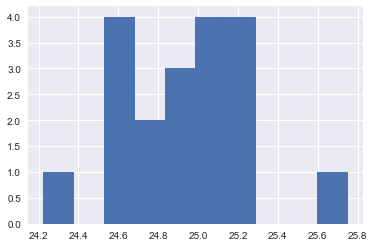

In [9]:
plt.hist(log_X_quiet)

(array([ 8.,  7.,  2.,  3.,  5.,  0.,  1.,  0.,  0.,  1.]),
 array([ 24.39168829,  24.92248303,  25.45327777,  25.98407251,
         26.51486725,  27.045662  ,  27.57645674,  28.10725148,
         28.63804622,  29.16884096,  29.6996357 ]),
 <a list of 10 Patch objects>)

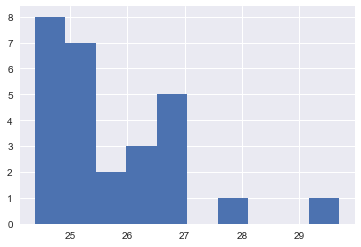

In [10]:
plt.hist(log_X_loud)

In [11]:
log_X = pd.DataFrame(dict(value=np.r_[log_X_quiet, log_X_loud], 
                          group=np.r_[['log_X_quiet']*len(log_X_quiet), ['log_X_loud']*len(log_X_loud)]))

In [12]:
mu_m = log_X.value.mean()
mu_s = log_X.value.std() * 2

sigma_low = log_X.value.std() *0.1
sigma_high = log_X.value.std() * 10

with pm.Model() as model_log_X:
    quiet_mean = pm.Normal('quiet_mean', mu_m, sd=mu_s)
    loud_mean = pm.Normal('loud_mean', mu_m, sd=mu_s)
    
    quiet_std = pm.Uniform('quiet_std', lower=sigma_low, upper=sigma_high)
    loud_std = pm.Uniform('loud_std', lower=sigma_low, upper=sigma_high)
    
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1
    
    quiet_lambda = quiet_std**-2
    loud_lambda = loud_std**-2
    
    quiet_group = pm.StudentT('quiet', nu=nu, mu=quiet_mean, lam=quiet_lambda, observed=log_X_quiet)
    loud_group = pm.StudentT('loud', nu=nu, mu=loud_mean, lam=loud_lambda, observed=log_X_loud)
    
    diff_of_means = pm.Deterministic('difference of means', quiet_mean - loud_mean)
    diff_of_stds = pm.Deterministic('difference of stds', quiet_std - loud_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((quiet_std**2 + loud_std**2) / 2))

In [14]:
#db_log_XEdot = pm.backends.text.load('trace_log_XEdot', model=model_log_XEdot)
with model_log_X:
    db_log_X = pm.backends.Text('trace_log_X')
    trace_log_X = pm.sample(25000, tune=2000, trace=db_log_X)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 27000/27000 [00:46<00:00, 582.78it/s]


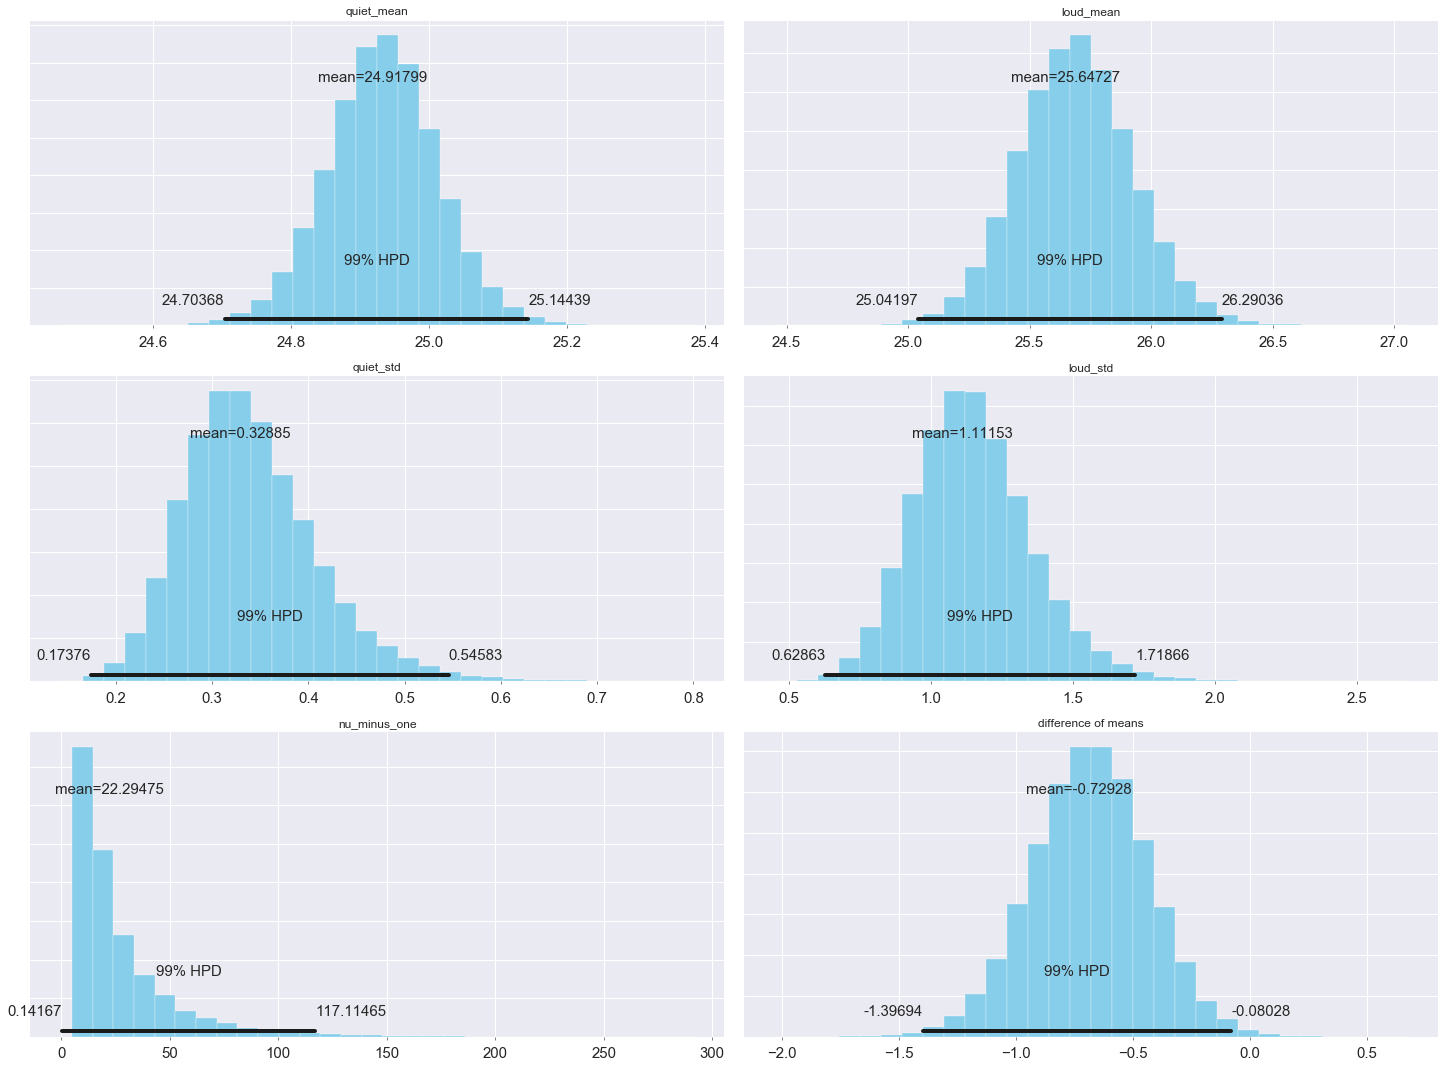

In [28]:
fig = pm.plot_posterior(trace_log_X, varnames=['quiet_mean','loud_mean','quiet_std','loud_std','nu_minus_one','difference of means'], 
                  alpha_level=0.01, figsize=(20, 15), text_size=15, round_to=5, color='#87ceeb')
#plt.savefig('trace_log_X.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Gamma

In [16]:
loudFile = open('RL_gamma.txt','r')
G_loud = loudFile.readline().split()
quietFile = open('RQ_gamma.txt','r')
G_quiet = quietFile.readline().split()

In [17]:
G_quiet = np.array(map(float, G_quiet))
G_loud = np.array(map(float, G_loud))

(array([ 4.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([  8.61800000e+33,   3.91162000e+34,   6.96144000e+34,
          1.00112600e+35,   1.30610800e+35,   1.61109000e+35,
          1.91607200e+35,   2.22105400e+35,   2.52603600e+35,
          2.83101800e+35,   3.13600000e+35]),
 <a list of 10 Patch objects>)

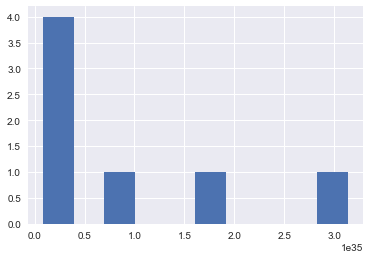

In [18]:
plt.hist(G_quiet)

(array([ 36.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.35300000e+32,   5.91611770e+35,   1.18298824e+36,
          1.77436471e+36,   2.36574118e+36,   2.95711765e+36,
          3.54849412e+36,   4.13987059e+36,   4.73124706e+36,
          5.32262353e+36,   5.91400000e+36]),
 <a list of 10 Patch objects>)

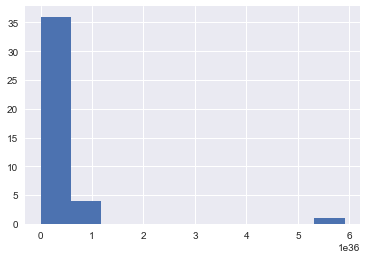

In [19]:
plt.hist(G_loud)

In [20]:
log_G_quiet = np.log10(G_quiet)
log_G_loud = np.log10(G_loud)

(array([ 1.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([ 33.93540649,  34.09150345,  34.2476004 ,  34.40369736,
         34.55979432,  34.71589127,  34.87198823,  35.02808518,
         35.18418214,  35.3402791 ,  35.49637605]),
 <a list of 10 Patch objects>)

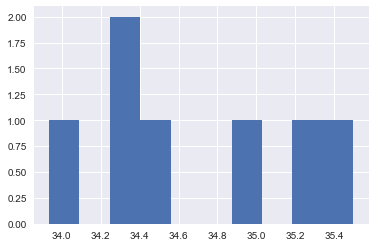

In [21]:
plt.hist(log_G_quiet)

(array([ 1.,  1.,  4.,  3.,  8.,  8.,  9.,  6.,  0.,  1.]),
 array([ 32.37162193,  32.81164787,  33.25167381,  33.69169975,
         34.13172568,  34.57175162,  35.01177756,  35.4518035 ,
         35.89182944,  36.33185538,  36.77188132]),
 <a list of 10 Patch objects>)

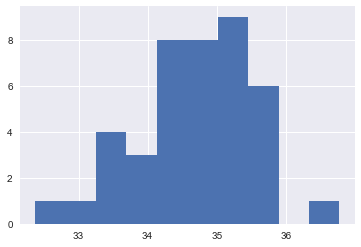

In [22]:
plt.hist(log_G_loud)

In [23]:
log_G = pd.DataFrame(dict(value=np.r_[log_G_quiet, log_G_loud], 
                          group=np.r_[['log_G_quiet']*len(log_G_quiet), ['log_G_loud']*len(log_G_loud)]))

In [24]:
mu_m = log_G.value.mean()
mu_s = log_G.value.std() * 2

sigma_low = log_G.value.std() *0.1
sigma_high = log_G.value.std() * 10

with pm.Model() as model_log_G:
    quiet_mean = pm.Normal('quiet_mean', mu_m, sd=mu_s)
    loud_mean = pm.Normal('loud_mean', mu_m, sd=mu_s)
    
    quiet_std = pm.Uniform('quiet_std', lower=sigma_low, upper=sigma_high)
    loud_std = pm.Uniform('loud_std', lower=sigma_low, upper=sigma_high)
    
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1
    
    quiet_lambda = quiet_std**-2
    loud_lambda = loud_std**-2
    
    quiet_group = pm.StudentT('quiet', nu=nu, mu=quiet_mean, lam=quiet_lambda, observed=log_G_quiet)
    loud_group = pm.StudentT('loud', nu=nu, mu=loud_mean, lam=loud_lambda, observed=log_G_loud)
    
    diff_of_means = pm.Deterministic('difference of means', quiet_mean - loud_mean)
    diff_of_stds = pm.Deterministic('difference of stds', quiet_std - loud_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((quiet_std**2 + loud_std**2) / 2))

In [25]:
#db_log_GEdot = pm.backends.text.load('trace_log_GEdot', model=model_log_GEdot)
with model_log_G:
    db_log_G = pm.backends.Text('trace_log_GEdot')
    trace_log_G = pm.sample(25000, tune=2000, trace=db_log_G)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 27000/27000 [00:45<00:00, 598.50it/s]


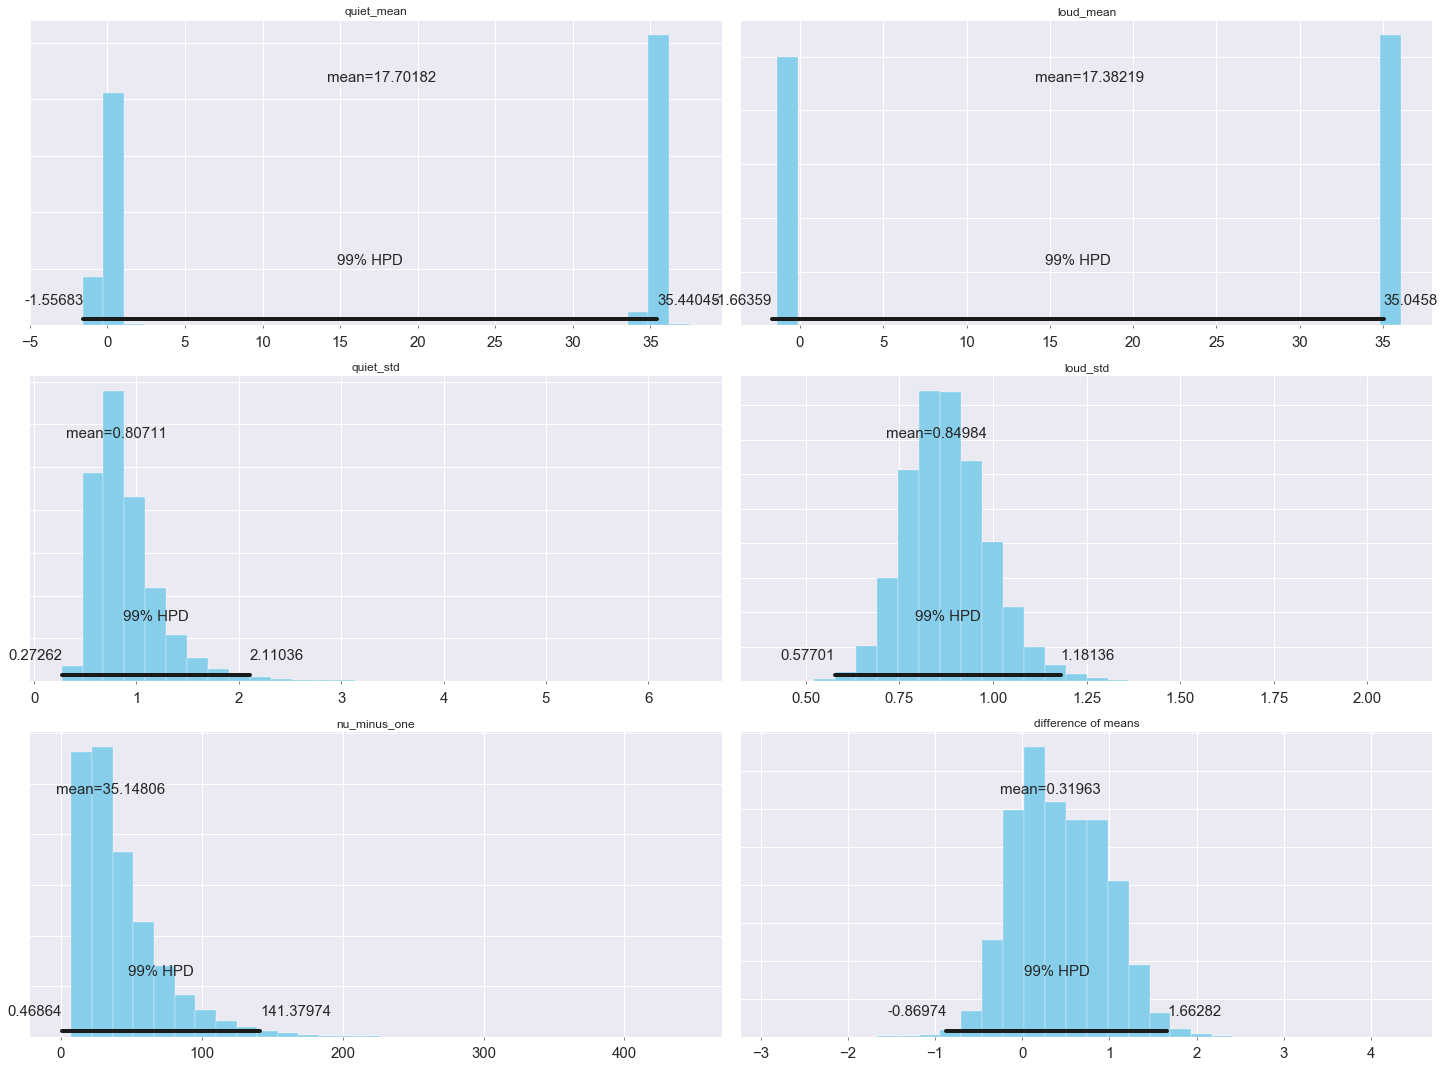

In [27]:
fig = pm.plot_posterior(trace_log_G, varnames=['quiet_mean','loud_mean','quiet_std','loud_std','nu_minus_one','difference of means'], 
                  alpha_level=0.01, figsize=(20, 15), text_size=15, round_to=5, color='#87ceeb')
#plt.savefig('trace_log_G.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)